# [CompuCell3D](http://compucell3d.org) in a Jupyter Notebook

> CompuCell3D is an open-source simulation environment for multi-cell, single-cell-based modeling of tissues, organs and organisms.

>It uses Cellular Potts Model to model cell behavior.

>This project is funded by the NIH and EPA.

>Compucell3D is led by Maciej Swat (IU), James Glazier(IU) and Roshan D'Souza (U.Wisc. Milwaukee) 

## Structure of the Simulations directory tree

* DATA_ROOT
    - ...
    - Sim2_cc3d_dd_MM_yyyy_hh_mm_ss
        * LatticeData
            - vtk_files ... **Here are the data**
        * Simulation
            - xml & python files ...
    
    
    - ...
    


### Parsing xml and python files

This is used for parameters management

In [33]:
import os
from xml.etree import ElementTree

import matplotlib.pylab as plt
%matplotlib inline
import vtk
from vtk.util.numpy_support import vtk_to_numpy


In [19]:
# TODO: do a widget for that
DATA_ROOT = '/home/guillaume/Projets/NeuroBlasts/CancerStemCells_GGH/simulation_data/'

folder_num = 5

data_dirs = os.listdir(DATA_ROOT)
data_dir = os.path.join(DATA_ROOT,
                        data_dirs[folder_num])

print('***************\n')
print('Using: #{} - {}\n'.format(folder_num, data_dir))


xml_file = os.path.join(data_dir+'/Simulation/Sim2.xml')
py_file = os.path.join(data_dir+'/Simulation/Sim2Steppables.py')

xml_tree = ElementTree.ElementTree(file=xml_file)
xml_root = xml_tree.getroot()

for child in xml_root:
    
    if child.tag == 'Potts':
        steps = int(child.find('Steps').text)
        dim = {k: int(v) for k, v 
               in child.find('Dimensions').items()}

    elif child.get('Name') == 'Contact':
        energies = child.findall('Energy')
        energies = {(energy.attrib['Type1'],
                     energy.attrib['Type2']):
                    float(energy.text) for energy in energies}

print('\n***************')
print('**  Energies **\n')

for e in energies.items(): 
    print(e)


pysettings = []
with open(py_file) as pf:
    for line in pf.readlines():
        if line.startswith('growth_rate') or line.startswith('P_'):
            pysettings.append(line)

for l in pysettings:
    exec(l)           
    

pyparams = {'growth_rate':growth_rate,
            'P_sr': P_sr,
            'P_ar': P_ar,
            'P_sd': P_sd}

print('\n***************')
print('**  python set variables **\n')

for p in pyparams.items():
    print(p)

vtk_dir = os.path.join(data_dir,'LatticeData')
                     
vtk_files = [os.path.join(vtk_dir, f) 
             for f in os.listdir(vtk_dir)
             if f.endswith('.vtk')]
vtk_files.sort()

print('\n***************')
print('**  VTK files **\n')
print('starts: {}\n stops: {}'.format(vtk_files[0], vtk_files[-1]))

***************

Using: #5 - /home/guillaume/Projets/NeuroBlasts/CancerStemCells_GGH/simulation_data/Sim2_cc3d_05_07_2015_11_51_27


***************
**  Energies **

(('Medium', 'Differentiated'), 30.0)
(('CancerStemCell', 'Differentiated'), 10.0)
(('CancerStemCell', 'CancerStemCell'), 5.0)
(('Medium', 'CancerStemCell'), 30.0)
(('Differentiated', 'Differentiated'), 5.0)
(('Medium', 'Medium'), 30.0)

***************
**  python set variables **

('P_sd', 0.19999999999999996)
('P_ar', 0.4)
('P_sr', 0.4)
('growth_rate', 0.1)

***************
**  VTK files **

starts: /home/guillaume/Projets/NeuroBlasts/CancerStemCells_GGH/simulation_data/Sim2_cc3d_05_07_2015_11_51_27/LatticeData/Step_000000.vtk
 stops: /home/guillaume/Projets/NeuroBlasts/CancerStemCells_GGH/simulation_data/Sim2_cc3d_05_07_2015_11_51_27/LatticeData/Step_008400.vtk


In [41]:
reader = vtk.vtkStructuredPointsReader()

vtk_fnum = -1
#reader = vtkUnstructuredGridReader()
reader.SetFileName(vtk_files[vtk_fnum])
reader.Update()
field_data = reader.GetOutput()
cell_type = vtk_to_numpy(field_data.GetPointData().GetArray('CellType')) ##CellId, ClusterId
cell_type = cell_type.reshape((dim['x'], dim['y']))
cell_id = vtk_to_numpy(field_data.GetPointData().GetArray('CellId')).reshape((dim['x'], dim['y']))
cluster_id = vtk_to_numpy(field_data.GetPointData().GetArray('ClusterId')).reshape((dim['x'], dim['y']))


reader.CloseVTKFile()

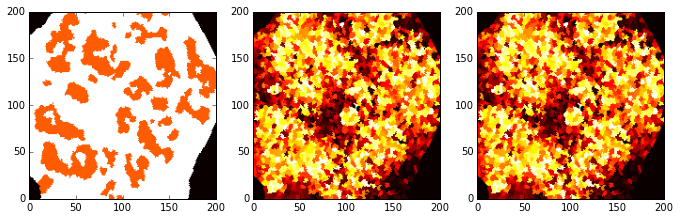

In [52]:
ppi = 90. # pixel per inch 
pix_width = 1024
pix_height = 720

f_size_i = (pix_width/ppi, pix_height/ppi)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(f_size_i)
for ax, data in zip(axes, [cell_type, cell_id, cluster_id]):
    ax.imshow(data[:200, :200], cmap='hot', origin='lower')